## Calculating Equilibrium Climate Sensitivity (ECS)$^{\star}$ in CMIP6 models

$^{\star}$This is a poor approximation for the ECS because most of the models are only run out 150 years and are thus far from reaching equilibrium, but my hope is that the analysis will still be illustrative or help improve people's workflows for processing CMIP6 analysis. I hope to enventually improve the analysis to implement the ["Gregory method"](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) which is based on a linear extrapolation of the relationship between radiative imbalance at the top of atmosphere and global-mean near-surface air temperature. In this method, the ECS is defined as the global-mean near-surface air temperature at which the linear extrapolation intercepts the zero radiative imbalance. This method produces estimates quite a bit larger – by a factor of 1.5 to 2 – than the estimates calculated here (see for example Section 8.3 of [Mauritsen et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001400)).

Hopefully I (or someone else – feel free to submit a pull request) will implement a tutorial for applying the "Gregory method" for estimating ECS. (Note: [Angeline Pendergrass' code](https://github.com/apendergrass/cmip6-ecs) already does this, but is not yet presented in a clear tutorial format).

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Data catalogs

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

In [3]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing.

In [4]:
df['experiment_id'].unique()

array(['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc', '1pctCO2',
       'abrupt-4xCO2', 'historical', 'piControl', 'amip', 'esm-hist',
       'esm-piControl', 'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
       'dcppA-hindcast', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 'dcppC-hindcast-noPinatubo',
       'highresSST-present', 'control-1950', 'hist-1950',
       'deforest-globe', 'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
       'ssp245', 'ssp585'], dtype=object)

In [17]:
df['variable_id'].unique()

array(['pr', 'prsn', 'tas', 'tasmax', 'tasmin', 'ts', 'ua', 'va', 'cLeaf',
       'cVeg', 'gpp', 'lai', 'npp', 'ra', 'tran', 'chl', 'detoc',
       'diftrblo', 'difvho', 'difvso', 'dissic', 'dissicabio',
       'dissicnat', 'fgco2', 'fgco2abio', 'fgco2nat', 'no3', 'o2', 'phyc',
       'phyn', 'pon', 'talk', 'zooc', 'nbp', 'fgo2', 'hfds', 'sos', 'tos',
       'calc', 'dfe', 'dissoc', 'expc', 'expn', 'expp', 'expsi', 'graz',
       'nh4', 'ph', 'phydiat', 'phydiaz', 'phypico', 'pnitrate', 'po4',
       'pp', 'remoc', 'si', 'hus', 'psl', 'ta', 'zos', 'zg', 'mlotst',
       'so', 'tauuo', 'tauvo', 'thetao', 'thetaoga', 'uo', 'vo', 'volo',
       'wo', 'sithick', 'huss', 'rlds', 'rlus', 'hfls', 'uas', 'vas',
       'ps', 'ch4', 'clt', 'co2', 'evspsbl', 'hfss', 'hurs', 'o3', 'prw',
       'rlut', 'rlutcs', 'rsds', 'rsdt', 'rsus', 'rsut', 'rsutcs', 'tauu',
       'tauv', 'snc', 'snw', 'cLitterAbove', 'cLitterBelow', 'cRoot',
       'cSoilFast', 'cSoilMedium', 'cSoilSlow', 'mrro', 'mrros', 'mr

# Analysis of Climate Model Output Data

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

#### Choice of simulated forcing experiments

Here, we choose the `piControl` experiment (in which CO2 concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-4xCO2` experiment (in which CO2 concentrations are instantaneously quadrupled - or doubled twice - from a pre-industrial controrl state). Since the radiative forcing of CO2 is roughly a logarithmic function of CO2 concentrations, the ECS is roughly independent of the initial CO2 concentration. Thus, if one doubling of CO2 results in $ECS$ of warming, then two doublings (or, a quadrupling) results in $2 \times ECS$ of warming.

To estimate the ECS, we thus compare the amount of warming between the `abrupt-4xCO2` simulation at equilibrium (in practice, we just take years 100-150 of the `abrupt-4xCO2` simulation, since most are only 150 years long) relative to the pre-industrial state in `piControl` (we pick the last 50 years for consistency).

Ideally, we would choose the `abrupt-2xCO2` forcing experiment, but this seems to be currently unavaiable in Google Cloud Storage.

In [24]:
cat_tas = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

cat_rad = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id=['rsut','rsdt','rlut'],           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [22]:
# convert data catalog into a dictionary of xarray datasets
#dset_dict_tas = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})
dset_dict_rad = cat_rad.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 33 group(s)


In [23]:
dset_dict_rad.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.piControl.Amon.gn', 'CMIP.BCC.BCC-ESM1.historical.Amon.gn', 'CMIP.BCC.BCC-ESM1.piControl.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn', 'CMIP.CAMS.CAMS-CSM1-0.piControl.Amon.gn', 'CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.CCCma.CanESM5.piControl.Amon.gn', 'CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr', 'CMIP.E3SM-Project.E3SM-1-0.piControl.Amon.gr', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr', 'CMIP.MIROC.MIROC6.historical.Amon.gn', 'CMIP.MIROC.MIROC6.piControl.Amon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.piControl.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.piControl.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn', 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn', 'CM

In [55]:

dset_dict = dict(dset_dict_tas, **dset_dict_rad)

ds_dict = {}
gmst_dict = {}
for name, ds in tqdm(dset_dict_rad.items()):
    model_name = name.split(".")[2]
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)

    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gmst = (
        (ds['tas'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )

    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 41 group(s)


MergeError: conflicting values for variable 'lat_bnds' on objects to be combined. You can skip this check by specifying compat='override'.

#### Split dictionary of all simulations into `piControl` and `abrupt-4xCO2` dictionaries

And get rid of any models that don't have both experiments available.

In [8]:
ctrl_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_dict[model_name] = ds
    
abrupt_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_dict.keys()): continue # keep only SSP simulations
    abrupt_dict[model_name] = ds

In [9]:
ctrl_gmst_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_gmst_dict[model_name] = gmst
    
abrupt_gmst_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_gmst_dict.keys()): continue # keep only SSP simulations
    abrupt_gmst_dict[model_name] = gmst

#### Pick first model arbitrarily to show example of warming patterns

In [10]:
model = list(ctrl_dict.keys())[0]
for name, ds in ctrl_dict.items():
    if model in name: ctrl_ds = ctrl_dict[name]
    
for name, ds in abrupt_dict.items():
    if model in name: abrupt_ds = abrupt_dict[name]
    

#### Visualizing warming patterns 100-150 years after quadrupling of CO2

In [30]:
temperature_change = (
    abrupt_ds['tas'].isel(time=np.arange(1200,1800)).mean(dim='time') -
    ctrl_ds['tas'].isel(time=np.arange(-600,0)).mean(dim='time')
).compute()
temperature_change.attrs.update(abrupt_ds['tas'].attrs)
temperature_change = temperature_change.rename(
    r'temperature change ($^{\circ}$C) due to quadrupling of CO2'
)

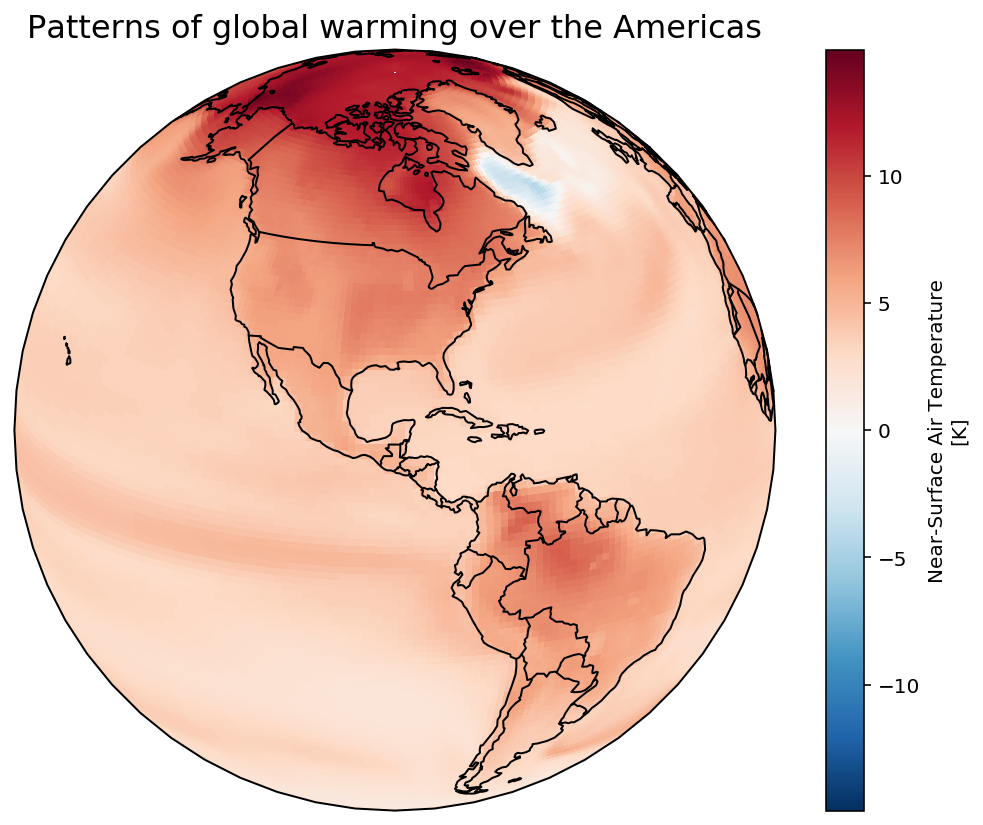

In [31]:
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(9,7))
ax = plt.subplot(1, 1, 1, projection=ortho)

q = temperature_change.plot(ax=ax, transform = geo) # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of global warming over the Americas',fontsize=16, ha='center');

#### Eagerly compute ECS for each model, in preparation for plotting

The operations we have done up to this point to calculate the global-mean surface temperature were evaluated lazily. In other worse, we have created a blueprint for how we want to evaluate the calculations, but have not yet computing them. This lets us do things like multiply two 1 Tb arrays together even though they are each individually larger-than-memory.

Now we call xarray's `compute()` method to carry out the computations we defined in the for loop above for calculation the global-mean surface temperature anomaly roughly 100-150 years (1200-1800 months) after instantaneous quadrupling of CO2 relative to the last 50 years (600 months) of the control simulation.

In [28]:
ECS_dict = {}
for name, gmst in tqdm(abrupt_gmst_dict.items()):
    gmst_change = (
        abrupt_gmst_dict[name].isel(time=np.arange(1200,1800)).mean(dim='time') -
        ctrl_gmst_dict[name].isel(time=np.arange(-600,0)).mean(dim='time')
    ).compute()
    
    # Divide by two to convert from temperature change due to quadrupling to temperature change due to doubling (ECS definition)
    ECS_dict[name] = gmst_change/2. 

#### Plot a histogram of the ECS in CMIP6 models

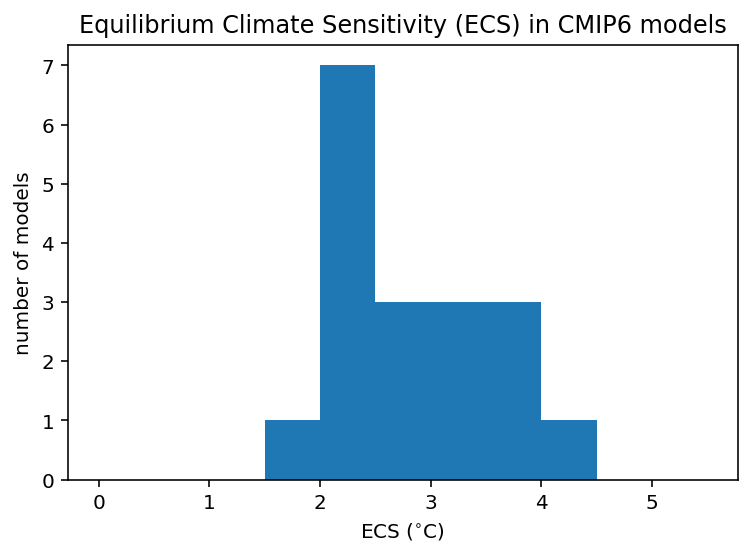

In [32]:
plt.hist(np.array(list(ECS_dict.values())),
         bins=np.arange(0,6,0.5))
plt.xlabel(r"ECS ($^{\circ}$C)")
plt.ylabel("number of models")
plt.title('Equilibrium Climate Sensitivity (ECS) in CMIP6 models')
plt.savefig("../figures/ECS.png",dpi=100)

## 